In [2]:
import torch
import torchvision
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader, Dataset
from scipy.optimize import linear_sum_assignment
from torchvision.transforms import v2 as T
from torchvision import models, datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor

In [3]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush', 'empty'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], 
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100


revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)

def plot_images_with_boxes(image, boxes, probs = None, ax = None):
    if ax is None:
        plt.imshow(image)
        ax = plt.gca()
        
    for idx, bbox in enumerate(boxes.tolist()):
        x_min, y_min, x_max, y_max = bbox
        patch = plt.Rectangle((x_min, y_min), width = x_max - x_min, height = y_max - y_min, fill=False, color=COLORS[idx], linewidth=2)
        ax.add_patch(patch)
        
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[idx].item()
                text = f"{CLASSES[cl]}"
            else:
                cl = probs[idx].argmax().item()
                text = f"{CLASSES[cl]}: {probs[idx, cl]:.2f}"
        else:
            text = ""
    
        ax.text(x_min+5, y_min+11, text, fontsize=7, bbox=dict(facecolor='yellow', alpha=0.5))
        
def preprocess_target(anno, image_w, image_h):
    anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]
    boxes = [obj['bbox'] for obj in anno]
    boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
    
    # xywh -> xyxy
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=image_w)
    boxes[:, 1::2].clamp_(min=0, max=image_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]
    
    classes = [obj['category_id'] for obj in anno]
    classes = torch.as_tensor(classes, dtype=torch.int64)
    classes = classes[keep]
    
    boxes[:, 0::2] /= image_w
    boxes[:, 1::2] /= image_h
    boxes.clamp_(min = 0, max = 1) 
    
    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')
    
    return classes, boxes

class MyCocoDetection(datasets.CocoDetection):
    def __init__(self, *args, **kwargs):
        super(MyCocoDetection, self).__init__(*args, **kwargs)
        self.size = 480
        self.T = T.Compose([
            T.ToImage(), 
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(
                mean=[.485, .456, .406],
                std=[.229, .224, .225]
            ),
            T.Resize(size=(self.size, self.size), antialias=True)
        ])
        self.T_target = preprocess_target
        
    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        image_w, image_h = image.size
        input_ = self.T(image)
        classes, boxes = self.T_target(target, image_w, image_h)
        return input_, (classes, boxes)

def collate_fn(inputs):
    input_ = torch.stack([i[0] for i in inputs])
    classes = tuple([i[1][0] for i in inputs])
    boxes = tuple(i[1][1] for i in inputs)
    
    return input_, (classes, boxes)


In [4]:
train_ds = MyCocoDetection(
    '../datasets/minicoco/train2017',
    '../datasets/minicoco/annotations/instances_minitrain2017.json'
)

train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f'\nNumber of training samples: {len(train_ds)}')

loading annotations into memory...
Done (t=1.36s)
creating index...
index created!

Number of training samples: 25000


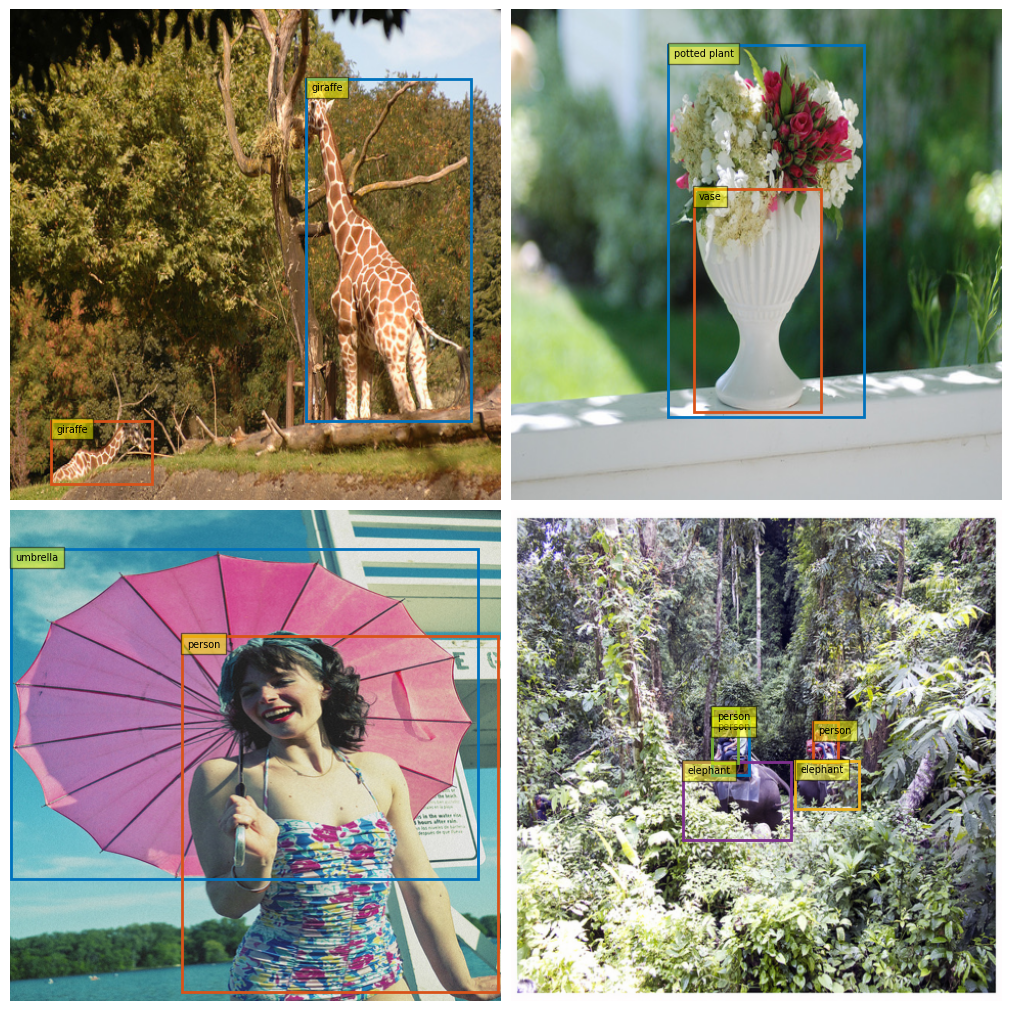

In [5]:
input_, (target) = next(iter(train_dataloader))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for ix in range(4):
    t_cl = target[0][ix].cuda()
    t_bbox = target[1][ix].cuda()

    t_bbox = ops.box_convert(
        t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].\
        permute(1,2,0).cpu().clip(0,1)

    ax = fig.add_subplot(2, 2, ix+1)
    ax.imshow(im)
    plot_images_with_boxes(im, t_bbox, t_cl, ax=ax)
    ax.set_axis_off()

In [6]:
_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

'''
_resnet = models.resnet50(pretrained=False)
_resnet.load_state_dict(torch.load('resnet50-0676ba61.pth'))
'''
backbone = create_feature_extractor(
    model = _resnet,
    return_nodes={
        'layer4': 'layer4'
    }
)

x = torch.rand(size=(1, 3, 480, 480))
embeddings = backbone(x)['layer4']

d_model = 256
conv1x1 = nn.Conv2d(in_channels=2048, out_channels=d_model, kernel_size=1, stride=1)
embeddings = conv1x1(embeddings)
x.shape, embeddings.shape


(torch.Size([1, 3, 480, 480]), torch.Size([1, 256, 15, 15]))

In [7]:
embeddings_old = embeddings.clone()
embeddings = rearrange(embeddings, 'b c h w -> b (h w) c')

embeddings_old.shape, embeddings.shape

(torch.Size([1, 256, 15, 15]), torch.Size([1, 225, 256]))

In [8]:
token_size = 225
pos_encode = nn.Parameter(torch.rand(size=(1, token_size, d_model)), requires_grad=False)
embeddings = pos_encode + embeddings

embeddings.shape, pos_encode.shape

(torch.Size([1, 225, 256]), torch.Size([1, 225, 256]))

In [9]:
n_heads = 8
encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=n_heads,
    dim_feedforward=4 * d_model,
    batch_first=True
)

num_layer = 4
encoder = nn.TransformerEncoder(encoder_layer, num_layer)

out = encoder(embeddings)
out.shape

torch.Size([1, 225, 256])

In [10]:
from torch import nn
from einops import rearrange

class DETR(nn.Module):
    def __init__(self, d_model=256, n_classes=92, n_tokens=225, n_layers = 6, n_heads = 8):
        super().__init__()
        _resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone = create_feature_extractor(
            model=_resnet,
            return_nodes={
                'layer4':'layer4'
            }
        )
        
        self.conv1x1 = nn.Conv2d(2048, d_model, kernel_size=1, stride=1)
        
        self.pos_encoding = nn.Parameter(torch.rand(size=(1, n_tokens, d_model)))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model, dropout=0.1, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
    
    def forward(self, x):
        x = self.backbone(x)['layer4']
        x = self.conv1x1(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        
        out_encoder = self.encoder(x + self.pos_encoding)
        return out_encoder
    
model = DETR()
x = torch.rand(size=(1, 3, 480, 480))
out_encoder = model(x)
out_encoder.shape

torch.Size([1, 225, 256])

Transformer解码器。解码器遵循Transformer的标准架构，使用多头自注意力和编码器-解码器注意力机制转换大小为d的N个嵌入。与原始Transformer的不同之处在于，我们的模型在每个解码器层并行解码N个对象，而Vaswani等人[47]使用自回归模型一次预测一个输出序列元素。对于不熟悉这些概念的读者，请参考补充材料。由于解码器也是置换不变的，因此N个输入嵌入必须不同才能产生不同的结果。这些输入嵌入是学习到的位置编码，我们将其称为对象查询，类似于编码器，我们将其添加到每个注意力层的输入中。N个对象查询由解码器转换为输出嵌入。然后，它们由前馈网络（在下一小节中描述）独立解码为边界框坐标和类别标签，从而产生N个最终预测结果。通过对这些嵌入使用自注意力和编码器-解码器注意力，模型能够全局地推理所有对象，利用它们之间的成对关系，同时能够使用整个图像作为上下文。

DETR 引入的一个亮点概念是对象查询。查询代表了对框预测的请求；因此，Q 个对象查询返回 Q 个框预测。从实际角度来看，查询是简单的 PE，输入到解码器。
一个注意事项：当同时运行 B 个实例时，Q 信息会被复制为 B 的长度；同样地，编码器的 PE 也会这样做。查询张量的形状为(B, Q, C)。

In [11]:
n_query = 100
object_query = nn.Parameter(torch.rand(size=(1, n_query, d_model)))

object_query.shape, out_encoder.shape

(torch.Size([1, 100, 256]), torch.Size([1, 225, 256]))

In [12]:
decoder_layer = nn.TransformerDecoderLayer(d_model, nhead=n_heads, dim_feedforward=4*d_model, dropout=0.1, batch_first=True)

transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layer)

out_decoder = transformer_decoder(object_query, out_encoder)

out_decoder.shape, object_query.shape, out_encoder.shape

(torch.Size([1, 100, 256]),
 torch.Size([1, 100, 256]),
 torch.Size([1, 225, 256]))

预测前馈网络（FFNs）。最终预测由一个具有ReLU激活函数和隐藏维度d的3层感知器和一个线性投影层计算得出。FFN预测盒子的归一化中心坐标、高度和宽度（相对于输入图像），线性层使用softmax函数预测类别标签。由于我们预测的是大小固定的N个边界框集合，其中N通常远大于图像中感兴趣对象的实际数量，因此使用额外的特殊类别标签∅来表示在某个槽位中未检测到任何对象。此类别与标准目标检测方法中的“背景”类别具有相似的作用。


In [13]:
n_classes = 92
linear_class = nn.Linear(d_model, n_classes)
linear_bbox = nn.Linear(d_model, 4)

In [14]:
import torch
from torch import nn
from torchvision import models
from einops import rearrange
from torchvision.models.feature_extraction import create_feature_extractor

class DETR(nn.Module):
    def __init__(self, d_model=256, n_tokens = 225, n_heads=8, n_layers=6, n_queries=100, n_classes=92):
        super().__init__()
        
        # backbone
        _resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone = create_feature_extractor(
            model=_resnet,
            return_nodes={
                "layer4": "layer4"
            }
        )
        self.conv1x1 = nn.Conv2d(in_channels=2048, out_channels=d_model, kernel_size=1, stride=1)
        
        # positional encoding
        self.pos_encoding = nn.Parameter(torch.rand(1, n_tokens, d_model), requires_grad=True)
        
        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        
        # object queries
        self.object_query = nn.Parameter(torch.rand(1, n_queries, d_model), requires_grad=True)
        
        # decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=0.1,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, n_layers)
        
        # FFD
        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)
    
    def forward(self, x):
        tokens = self.conv1x1(self.backbone(x)['layer4'])     # (b d h w)
        tokens = rearrange(tokens, 'b c h w -> b (h w) c') + self.pos_encoding      # (b (h w) d) + (b token d)
        
        enc_out = self.encoder(tokens)
        dec_out = self.decoder(self.object_query.repeat(enc_out.shape[0], 1, 1), enc_out)   # fit batch_size
        
        out = {
            'cl': self.linear_class(dec_out),
            'bbox': self.linear_bbox(dec_out)
        }
        
        return out
    
x = torch.rand(size=(16, 3, 480, 480))
model = DETR()
out_cl, out_bbox = model(x).values()
print(out_cl.shape, out_bbox.shape)

torch.Size([16, 100, 92]) torch.Size([16, 100, 4])


In [ ]:
def compute_sample_loss(pred_bbox, target_bbox, pred_class, target_class, n_queries=100):
    # if the example has none box, just feed it with empty classes.
    if len(target_class) > 0:
        target_bbox = target_bbox.cuda()
        target_class = target_class.cuda()
        
        pred_probs = torch.softmax(pred_class, dim=-1)
        
        # Negative sign here because we want the maximum magnitude
        C_classes = -pred_probs[..., target_class]
        
        # Positive sign here because we want to shrink the l1-norm
        C_boxes = torch.cdist(pred_bbox, target_bbox, p=1)
        
        # Negative sign here because we want the maximum magnitude
        C_giou = ops.generalized_box_iou(
            ops.box_convert(pred_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(target_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        )
        
        C_total = 1*C_classes + 5*C_boxes + 2*C_giou
        C_total = C_total.cpu().detach().numpy()
        
        pred_ixs, target_ixs = linear_sum_assignment(C_total)
        
        

IndexError: index 25 is out of bounds for dimension 0 with size 4